# CMIP6 AOPD/AOT comparison against ground-based and satellite remote sensing

- compare CMIP6 with MERRA2

### Visualiztion of AOD for Svalbard area 5E, 72N - 27E, 83N

In [1]:
from dask.distributed import Client


In [2]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='2GB')
client
chunks={
    'time' : 10,  
}

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
import pandas as pd
from glob import glob
from functions import masked_average


#%matplotlib inline
#plt.ion()

In [4]:
# set plotting style
plt.style.use('ggplot')
sns.set_context('paper')
sns.set(font = 'Serif', font_scale = 1.8, )
sns.set_style('darkgrid',
                  {'font.family':'serif', #'font.serif':'Helvetica'
                   'grid.linestyle': '--'           },
                   )

In [5]:
## area which shall be used for AOD average
# should be similar as MERRA2 data
lllat = 75; lllon = -15
urlat = 82; urlon = 10

In [6]:
hist_path = 'shared-cmip6-for-ns1000k/historical/'
model_path = ['AWI-CM-1-1-MR', 'CESM2','EC-Earth3','GFDL-ESM4','IPSL-CM6A-LR',
              'NESM3', 'BCC-CSM2-MR', 'CESM2-WACCM', 'EC-Earth3-Veg', 'GISS-E2-1-G',
              'MCM-UA-1-0', 'NorCPM1','BCC-ESM1','CNRM-CM6-1','FGOALS-f3-L','GISS-E2-1-G-CC',
              'MIROC6','NorESM2-LM','CAMS-CSM1-0','CNRM-ESM2-1','FGOALS-g3','GISS-E2-1-H',
              'MIROC-ES2L','SAM0-UNICON','CanESM5','E3SM-1-0','GFDL-CM4','HadGEM3-GC31-LL',
              'MRI-ESM2-0','UKESM1-0-LL']

merra_path = 'g4.areaAvgTimeSeries.M2IMNXGAS_5_12_4_AODANA.19800101-20141231.15W_75N_10E_82N.csv' 

### Print all CMIP6 historical simulations including the AOD at 550nm (1850 - 2014)

In [7]:
for mp in range(len(model_path)):
    for _files in glob(hist_path + model_path[mp] + '/r*/od550aer_AERmon_*'):
        print(_files)

shared-cmip6-for-ns1000k/historical/CESM2/r1i1p1f1/od550aer_AERmon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc
shared-cmip6-for-ns1000k/historical/GFDL-ESM4/r1i1p1f1/od550aer_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc
shared-cmip6-for-ns1000k/historical/GFDL-ESM4/r1i1p1f1/od550aer_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_185001-194912.nc
shared-cmip6-for-ns1000k/historical/IPSL-CM6A-LR/r1i1p1f1/od550aer_AERmon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc
shared-cmip6-for-ns1000k/historical/CESM2-WACCM/r1i1p1f1/od550aer_AERmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc
shared-cmip6-for-ns1000k/historical/CNRM-CM6-1/r1i1p1f2/od550aer_AERmon_CNRM-CM6-1_historical_r1i1p1f2_gr_185001-201412.nc
shared-cmip6-for-ns1000k/historical/NorESM2-LM/r1i1p1f1/od550aer_AERmon_NorESM2-LM_historical_r1i1p1f1_gn_194001-194912.nc
shared-cmip6-for-ns1000k/historical/NorESM2-LM/r1i1p1f1/od550aer_AERmon_NorESM2-LM_historical_r1i1p1f1_gn_193001-193912.nc
shared-cmip6-for-ns100

### Read all CMIP6 historical simulation including the AOD at 550nm (1980 - 2014)

In [8]:
cmip={}
for mp in range(len(model_path)):
    # loop over realisations (the r1ii)
    md_n = model_path[mp]
    cmip[md_n]={}
    for rea in glob(hist_path + model_path[mp]+'/*'):
        _r= rea.split('/')[-1]
        li_ds=[]
        fn_list = [fn for fn in glob(hist_path + model_path[mp]+ '/%s/od550aer_AERmon_*.nc'%_r) if (int(fn[-9:-5])>1980)]
        fn_areac= [fn for fn in glob(hist_path + model_path[mp]+ '/%s/areacella*.nc'%_r)]
#        print(fn_list)
        
        if len(fn_list)>0:
            _ds= xr.open_mfdataset(fn_list, chunks=chunks,parallel=True, use_cftime = True)#, compat='override')
            
            if len(fn_areac):
                _dsa = xr.open_dataset(fn_areac[0])
                _ds['areacella'] = _dsa['areacella']
            cmip[md_n][_r] = _ds#xr.merge([_ds, _dsa])
            ### Shift the longitude from 0 --> 360 to -180 --> 180
            
            cmip[md_n][_r] = cmip[md_n][_r].assign_coords(lon=(((cmip[md_n][_r].lon + 180) % 360) - 180)).sortby('lon').sortby('time')
            
        
        #    print(fn)
        #    endy= int(fn[-9:-5])
        #    if endy>1980:
        #        li_ds.append(xr.open_dataset(fn))
        #if len(li_ds)>0:
        #    cmip[md_n][_r]= xr.concat(li_ds, dim='time')
            
     


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/opt/conda/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/opt/conda/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'areacella' has multiple fill values {1e+

In [9]:
for mp in cmip.keys():
    for res in cmip[mp].keys():
        if 'areacella' not in cmip[mp][res]:
            print(mp)
            print(res)

CNRM-ESM2-1
r1i1p1f2
HadGEM3-GC31-LL
r1i1p1f3
UKESM1-0-LL
r1i1p1f2


# Plot selected area for chosen year of chosen model

In [11]:
choseny = '2006'

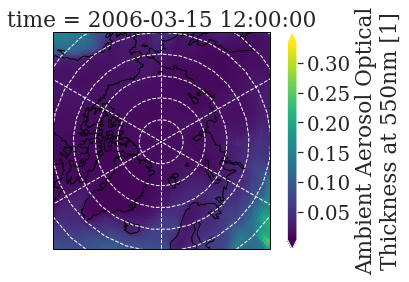

In [12]:
fig, ax = plt.subplots(1, #figsize = [30,13], 
                       subplot_kw={'projection': ccrs.AzimuthalEquidistant(central_longitude=0,
                                                                           central_latitude=90,)})
cmip['CESM2']['r1i1p1f1']['od550aer'].sel(time=choseny + '-03').plot(ax=ax,
                                                                     transform=ccrs.PlateCarree(),
                                                                     robust=True)
# Limit the map degrees latitude 
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

ax.coastlines()
ax.gridlines()

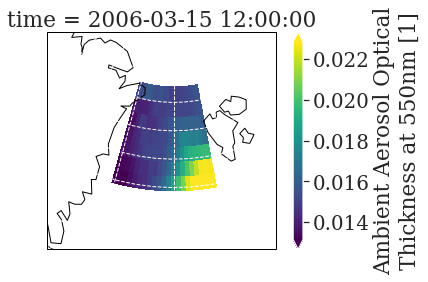

In [13]:
fig, ax = plt.subplots(1, #figsize = [30,13], 
                       subplot_kw={'projection': ccrs.AzimuthalEquidistant(central_longitude=0,
                                                                           central_latitude=90,)})
cmip['CESM2']['r1i1p1f1']['od550aer'].sel(time=choseny + '-03',
                                               lat=slice(lllat,urlat,1),
                                               lon=slice(lllon,urlon)).plot(ax=ax,
                                                                        transform=ccrs.PlateCarree(),
                                                                        robust=True)
# Limit the map degrees latitude 
ax.set_extent([-25, 20, 85, 71], ccrs.PlateCarree())

ax.coastlines()
ax.gridlines()
#plt.savefig('AOD_Svalbard.png')


### Read MERRA2 data 

In [14]:
starty = '1980'; endy = '2014'

In [15]:
merra_hist = pd.read_csv(merra_path, header = 7, index_col = 'time', parse_dates=True, 
                         skipinitialspace=True)

##### Rename the MERRA2 column

In [16]:
merra_hist.rename(columns={'mean_M2IMNXGAS_5_12_4_AODANA':'MERRA2'}, inplace=True)
merra_hist.shape

(420, 1)

## ADD CMIP6 weigted arctic average to the MERRA2: 
###  take only the data above chosen lower lat

In [17]:
for md in cmip.keys():
    for rea  in cmip[md].keys():
        print(md, rea)
        try:
            aw_xr = cmip[md][rea]['areacella']
            mask  = cmip[md][rea]['lat'] <= (lllat-3)
            merra_hist.insert(loc=1,
                              column= md + '_' + rea,
                              value = masked_average(cmip[md][rea]['od550aer'].sel(time = slice(starty + '-01', endy + '12'),
                                                                                   lat = slice(lllat, urlat),
                                                                                   lon = slice(lllon, urlon)), 
                                                     dim=['lat','lon'], 
                                                     weights=aw_xr, 
                                                     mask=mask))
        except KeyError:
            print('no areacella data:', md+'_'+rea)

CESM2 r1i1p1f1
GFDL-ESM4 r1i1p1f1
IPSL-CM6A-LR r1i1p1f1
CESM2-WACCM r1i1p1f1
CNRM-CM6-1 r1i1p1f2
NorESM2-LM r1i1p1f1
CNRM-ESM2-1 r1i1p1f2
no areacella data: CNRM-ESM2-1_r1i1p1f2
MIROC-ES2L r1i1p1f2
CanESM5 r1i1p2f1
CanESM5 r1i1p1f1
E3SM-1-0 r1i1p1f1
GFDL-CM4 r1i1p1f1
HadGEM3-GC31-LL r1i1p1f3
no areacella data: HadGEM3-GC31-LL_r1i1p1f3
UKESM1-0-LL r1i1p1f2
no areacella data: UKESM1-0-LL_r1i1p1f2


## Plot years with Volcanic eruptions, forest fires and Arctic haze

In [18]:
#choseny = '2006'    # arctic haze year in Russia forest fire
#choseny = '2004'     # arctic haze in Canada forest fire
#choseny = '1992'    # year after Pinatubo erruption
#### Russian Vulcano eruptions:
#choseny = '2010'     # Sarychev Peak 11-21 Jun 2009

cases_yr = ['1992', '2004', '2006', '2010']
cases_desc =  ['yr after Mt. Pinatubo eruption',
               'Arctic haze, CAN forest fire',
               'Arctic haze, RUS forest fire',
               'Sarychev Peak eruption']


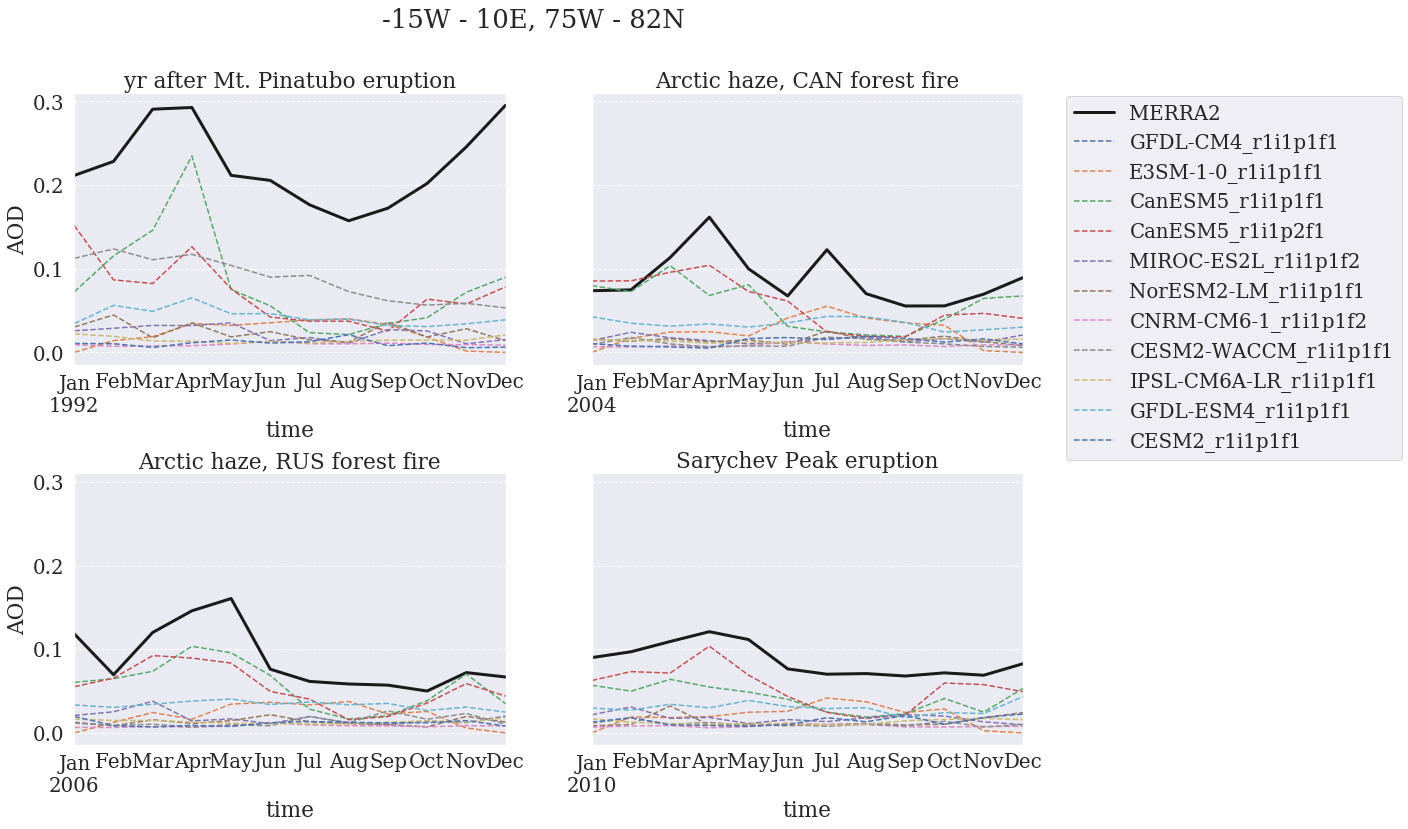

In [20]:
fig, axsm = plt.subplots(2, 2, #sharex='all',
                         sharey='all',
                         figsize=[17,12],
                        ) 

axs = axsm.flatten()
for i in range(len(cases_yr)):
    merra_hist['MERRA2'].loc[cases_yr[i] + '-01' : cases_yr[i] + '-12'].plot(ax=axs[i], 
                                                                          color = 'k', 
                                                                          linewidth=3)
    if i == len(cases_yr):
        merra_hist[merra_hist.columns[1:]].loc[cases_yr[i] + '-01' : cases_yr[i] + '-12'].plot(ax=axs[i], linestyle = '--', legend=True)
    else:
        merra_hist[merra_hist.columns[1:]].loc[cases_yr[i] + '-01' : cases_yr[i] + '-12'].plot(ax=axs[i], linestyle = '--', legend=False)
        
    axs[i].set_title(cases_desc[i])
    axs[i].set_ylabel('AOD')

plt.suptitle('%sW - %sE, %sW - %sN' %(lllon,urlon,lllat,urlat));
axs[len(cases_yr)-1].legend(bbox_to_anchor=(1.1, 1.05), loc='lower left', borderaxespad=0., fancybox=True);
plt.subplots_adjust(wspace = 0.2,   # the amount of width reserved for blank space between subplots
                    hspace = 0.4   # the amount of height reserved for white space between subplots
                   )

## Plot mean of AOD for 1980 - 2014

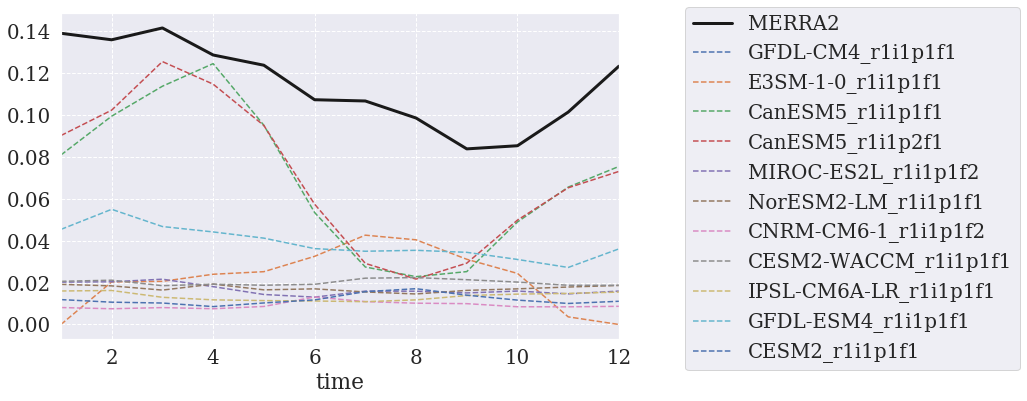

In [21]:
fig, ax = plt.subplots(1,
                       figsize=[10,6],)

merra_hist['MERRA2'].loc[starty + '-01': endy + '-12'].groupby(merra_hist.loc[starty + '-01': endy + '-12'].index.month).mean().plot(ax=ax, color = 'k', linewidth=3)
merra_hist[merra_hist.columns[1:]].loc[starty + '-01': endy + '-12'].groupby(merra_hist.loc[starty + '-01': endy + '-12'].index.month).mean().plot(ax=ax, linestyle = '--')

ax.legend(bbox_to_anchor=(1.1, 1.05));#, loc='lower left', borderaxespad=0., fancybox=True);

In [69]:
pd_mean = merra_hist.loc[starty + '-01' : endy + '-12'].groupby(merra_hist.loc[starty + '-01': endy + '-12'].index.month).mean()
pd_std = merra_hist.loc[starty + '-01' : endy + '-12'].groupby(merra_hist.loc[starty + '-01': endy + '-12'].index.month).std()

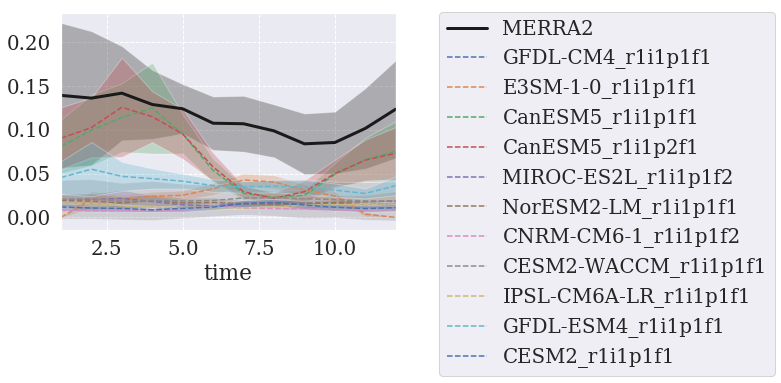

In [116]:
fig, ax = plt.subplots(1,)

pd_mean['MERRA2'].plot(ax=ax, color = 'k', linewidth=3)
ax.fill_between(pd_mean['MERRA2'].index, 
                (pd_mean-pd_std)['MERRA2'], 
                (pd_mean+pd_std)['MERRA2'],alpha=0.3,facecolor='k')

pd_mean[pd_mean.columns[1:]].plot(ax=ax, linestyle='--')
for i in range(1,pd_mean.shape[1]):
    ax.fill_between(pd_mean[pd_mean.columns[i]].index,
                    pd_mean[pd_mean.columns[i]]-pd_std[pd_std.columns[i]],
                    pd_mean[pd_mean.columns[i]]+pd_std[pd_std.columns[i]], alpha=0.3)
#ax.fill_between(pd_mean[pd_mean.columns[1:]].index, 
 #               (pd_mean-pd_std)[pd_mean.columns[1:]], 
  #              (pd_mean+pd_std)[pd_mean.columns[1:]],alpha=0.3)

ax.legend(bbox_to_anchor=(1.1, 1.05));

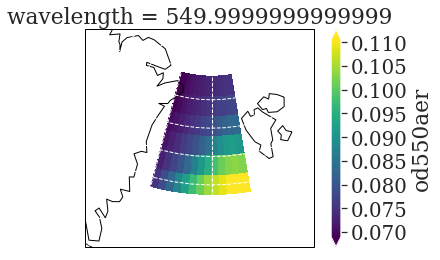

In [118]:
starty = '1980'; endy = '2014'
fig, ax = plt.subplots(1, #figsize = [30,13], 
                       subplot_kw={'projection': ccrs.AzimuthalEquidistant(central_longitude=0,
                                                                           central_latitude=90,)})
cmip[md][rea]['od550aer'].sel(time = slice(starty + '-01', endy + '12'),
                                                                              lat = slice(lllat, urlat),
                                                                              lon = slice(lllon, urlon)).mean('time').plot(ax=ax,
                                                                        transform=ccrs.PlateCarree(),
                                                                        robust=True)

# Limit the map degrees latitude 
ax.set_extent([-25, 20, 85, 71], ccrs.PlateCarree())

ax.coastlines()
ax.gridlines()
#plt.savefig('AOD_Svalbard.png')


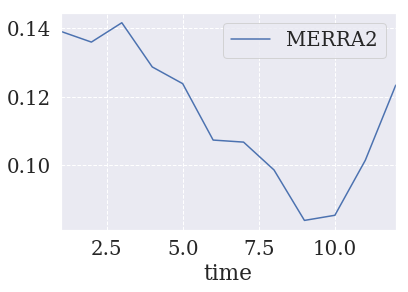